# Stress Detection Models 

In this notebook we are going to be testing three approaches for stress detection using biosignals like Heart Rate and/or Heart Rate Variability for each one of the following datasets:

1. [Nurse Stress Prediction Wearable Sensors](https://www.kaggle.com/datasets/priyankraval/nurse-stress-prediction-wearable-sensors)
2. [Heart Rate Prediction to Monitor Stress Level](https://www.kaggle.com/datasets/vinayakshanawad/heart-rate-prediction-to-monitor-stress-level)
3. [Stress-Predict-Dataset](https://github.com/italha-d/Stress-Predict-Dataset)
4. [SWELL dataset](https://www.kaggle.com/datasets/qiriro/swell-heart-rate-variability-hrv)




In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data Paths
data_path = os.getcwd() + "/data" 

---

# Nurse Stress Prediction Wearable Sensors

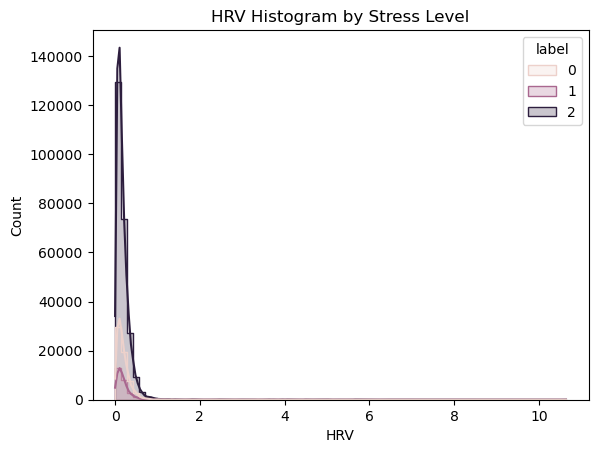

In [2]:
data = pd.read_csv(data_path + "/Healthcare/hrv.csv")

# Optional: Histogram
sns.histplot(data=data, x='HRV', hue='label', kde=True, element="step", bins=75)
plt.title("HRV Histogram by Stress Level")
plt.show()